# 앙상블
- 여러개의 분류모델을 조합해서 더 나은 성능을 내는 방법

## RandomForest
:의사결정트리 baggig(단일 모델 조합)해서 예측을 실행하는 모델

In [1]:
from sklearn import datasets

import numpy as np
np.random.seed(5)

In [2]:
# 손글씨 데이터
mnist = datasets.load_digits()
features, labels = mnist.data,mnist.target

In [3]:
mnist.data

array([[ 0.,  0.,  5., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ..., 10.,  0.,  0.],
       [ 0.,  0.,  0., ..., 16.,  9.,  0.],
       ...,
       [ 0.,  0.,  1., ...,  6.,  0.,  0.],
       [ 0.,  0.,  2., ..., 12.,  0.,  0.],
       [ 0.,  0., 10., ..., 12.,  1.,  0.]])

In [4]:
mnist.target

array([0, 1, 2, ..., 8, 9, 8])

In [5]:
# 의사결정 나무를 이용한 10번의 교차 검증 10번 실시 => 정확도의 차이를 보기 위해서...
from sklearn import tree
from sklearn.model_selection import cross_val_score

cv_scores = []

cv = tree.DecisionTreeClassifier()

for i in range(0,10):
    score = cross_val_score(cv,features,labels,cv=10,scoring='accuracy')
    cv_scores.append(score.mean())
cv_scores

[0.8280229671011794,
 0.8235630043451273,
 0.8224674115456239,
 0.8235692116697703,
 0.8341464928615766,
 0.8185692116697704,
 0.8241247672253259,
 0.8180136561142148,
 0.8235630043451272,
 0.8258038485412786]

In [6]:
# RandomForest를 이용한 교차검증 10번
from sklearn.ensemble import RandomForestClassifier

cv_scores = []

rf = RandomForestClassifier()

for i in range(0,10):
    score1 = cross_val_score(rf,features,labels,cv=10,scoring='accuracy')
    cv_scores.append(score1.mean())
cv_scores

[0.9526939788950962,
 0.9487957790192427,
 0.9510211049037863,
 0.9549286157666046,
 0.9471322160148976,
 0.9487988826815641,
 0.952122905027933,
 0.9454531346989447,
 0.9460180012414648,
 0.9471322160148976]

In [7]:
def cross_validation(classifier,features,labels):
    cv_scores=[]
    for i in range(0,10):
        score1 = cross_val_score(classifier,features,labels,cv=10,scoring='accuracy')
        cv_scores.append(score1.mean())
    return cv_scores

In [8]:
# 의사결정 나무
dt_cv_scores = cross_validation(tree.DecisionTreeClassifier(),features,labels)
dt_cv_scores

[0.8330509000620733,
 0.8224736188702669,
 0.8268963376784605,
 0.8246710117939168,
 0.825788330229671,
 0.821880819366853,
 0.833584729981378,
 0.8280167597765363,
 0.826340782122905,
 0.8235816263190564]

In [9]:
# RandomForest
rf_cv_scores = cross_validation(RandomForestClassifier(),features,labels)
rf_cv_scores

[0.9504655493482307,
 0.9410117939168219,
 0.9510211049037863,
 0.9549162011173185,
 0.9504469273743016,
 0.9449130974549969,
 0.9510117939168218,
 0.9493513345747981,
 0.9488081936685286,
 0.9471198013656114]

### 랜덤포레스트와 의사결정나무의 정확도의 시각화


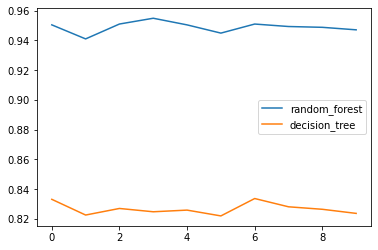

In [10]:
import matplotlib.pyplot as plt
import pandas as pd

cv_list = {'random_forest':rf_cv_scores,'decision_tree':dt_cv_scores}
df = pd.DataFrame(cv_list)
df.plot()
plt.show()

---
# 보팅(voting) 앙상블
: 단일 모델을 앙상블하여 더나은 예측을 하는 모델 생성

In [11]:
from sklearn.model_selection import train_test_split

In [12]:
X_train,X_test,y_train,y_test = train_test_split(features,labels,test_size=0.2)

### 단일 모델 정확도 측정

In [13]:
# 의사결정 나무
dtree = tree.DecisionTreeClassifier()
dree = dtree.fit(X_train,y_train)
dtree_score = dtree.score(X_test,y_test)
print("d-tree: ",dtree_score)

d-tree:  0.8638888888888889


In [14]:
# KNN
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier().fit(X_train,y_train)
knn_score = knn.score(X_test,y_test)
print("knn : ",knn_score)

knn :  0.9805555555555555


In [15]:
# SVM
from sklearn.svm import SVC
svm = SVC(probability=True).fit(X_train,y_train)
svm_score = svm.score(X_test,y_test)
print("svm : ",svm_score)

svm :  0.9861111111111112


### 하드 보팅
:각각의 분류기의 예측값들을 모아, 가장 많은 득표를 받은 예측값으로 최종 결론을 내는 방식입니다.

In [16]:
from sklearn.ensemble import VotingClassifier
voting_clf = VotingClassifier(
    estimators=[('descion_tree',dtree),('knn',knn),('svm',svm)],
    weights=[1,1,1],
    voting='hard'
).fit(X_train,y_train)
voting_clf.score(X_test,y_test)

0.9861111111111112

> estimators의 방법들 중 가장 예측률이 높은 것이 최종으로 결정

### 소프트 보팅
: 각각의 분류모델을 활용하여 모든 분류값들의 확률들을 더해서 가장 높은 점수를 획득한 분류값으로 최종결론을 내는 방식입니다.

In [17]:
voting_clf = VotingClassifier(
    estimators=[('descion_tree',dtree),('knn',knn),('svm',svm)], 
    # 소프트 코팅은 확률값들을 계산하므로 svm 선언시,확률값을 true해야함
    weights=[1,1,1],
    voting='soft'
).fit(X_train,y_train)
voting_clf.score(X_test,y_test)

0.9833333333333333

> estimators의 각 예측률 중 많이 나온 것을 채택. 예로 80점 2개, 90점 1개가 나올 경우 80점을 최종으로 결정 
